## 문제 정의
### Problem
- format : regression

### Input
- definition : closing price which is scaled and not one-hot encoded including 5 timesteps of data
- format : [sample, timesteps, features]

### Output
- definition : next 5 timesteps of closing price of the Input data which is scaled and not one-hot encoded
- format : [timesteps, features]

## Current Version Review
### Current Version Summary

### Current Version Result

### Takeaways

### Todos
- softmax 로 복귀하여 다른 optimizer 와 loss function 을 테스트
- 정수값 label 에서 sparse_categorical_crossentropy 테스트
- 위 두 경우에 encoder/decoder 구조는 그대로 sequential을 유지
- ㄴ 함수형 API로 작업되었던 것을 그대로 sequential로 컨버팅해 보기

### 0. Import Libraries

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import requests, json
from urllib.parse import quote
from numpy import array, argmax, array_equal
from random import randint


from keras import backend, optimizers
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from keras.utils import to_categorical

from attention_decoder import AttentionDecoder

### 1. Load Data

In [79]:
dataset = load_data('XRP', 1, 10000)
train, test = split_data(x=dataset)
print('train shape:',train.shape)
print('test shape:', test.shape)

train shape: (9000, 11)
test shape: (1000, 11)


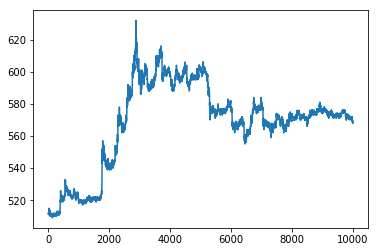

In [80]:
plt.plot(dataset[:,[6]].astype(float)) # todo : 플롯 스타팅 포인트(x) 바꿔그리기

### 2. Set constant values / hyperparameters

In [212]:
col=[6]
input_seq = 5
output_seq = 5
hidden = 1000
batch_size = 512
epoch = 10
features = 1000

### 3. Process data / Split to train and test

In [213]:
meta, x, y, x2 = feed_maker(train, col, scale=False)

### 4. Build / Train Model

In [214]:
model = define_models(5,1000)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [215]:
hist = model.fit(x, y, batch_size=batch_size, epochs=epoch, validation_split=0.1)

Train on 8091 samples, validate on 900 samples
Epoch 1/10
8091/8091 [==============================] - 92s 11ms/step - loss: 4.9416 - acc: 0.2237 - val_loss: 2.1537 - val_acc: 0.3253
Epoch 2/10
1024/8091 [==>...........................] - ETA: 1:10 - loss: 2.6074 - acc: 0.2816

KeyboardInterrupt: 

### 5. Show trained result

8991/8991 [==============================] - 4s 471us/step
Loss: 0.003979589991628238 Acc: 1.0


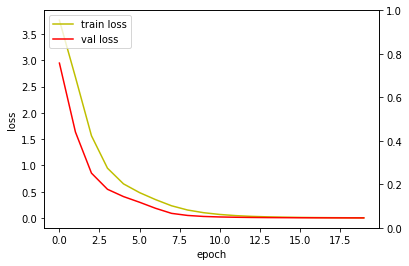

In [196]:
#results
test_model(model, [x,x2], y)

#graph
show_graph(hist)

### 6. Predict Future data using trained model

In [197]:
meta, test_x, test_y, test_x2 = feed_maker(test, col, scale=False, is_training=False, v=meta)

In [198]:
print(one_hot_decode(test_x[0]))
print(one_hot_decode(test_y[0]))
print(one_hot_decode(test_predict[0]))

[575, 574, 575, 575, 575]
[0, 574, 575, 574, 575]
[575, 575, 575, 575, 575]


In [199]:
# predict = get_accuracy(test_x, test_y)
# for i in range(5):
#     print('y:%s, predict:%s'%(scaler_decode(test_y[i],meta).reshape(1,-1), scaler_decode(predict[i],meta).round().reshape(1,-1)))

test_predict = predict_data(test_x)

show_result_samples(10, test_predict.shape[0])
eval_strict = get_eval_strict()
eval_isclose = get_eval_isclose(3)
#업다운 추세에 대한 평가지표를 하나 더 추가. 이건 mse가 더 잘 어울리나? 일단은..

print('')
print('[Evaluation Results(%)]')
print('Strict Equality :%s, IsClose Equality :%s'%(round(eval_strict,2), round(eval_isclose,2)))

[Example Data]
Index=963 X=[571, 571, 572, 572, 572] y=[0, 572, 571, 571, 572], yhat=[0, 0, 569, 567, 521]
Index=521 X=[573, 573, 573, 573, 573] y=[0, 572, 572, 572, 572], yhat=[0, 0, 569, 567, 521]
Index=445 X=[574, 573, 573, 573, 574] y=[0, 573, 573, 573, 573], yhat=[0, 0, 521, 574, 521]
Index=537 X=[571, 571, 572, 572, 571] y=[0, 571, 572, 572, 571], yhat=[0, 0, 569, 567, 569]
Index=730 X=[576, 576, 576, 576, 576] y=[0, 576, 575, 576, 576], yhat=[0, 0, 575, 574, 575]
Index=316 X=[574, 574, 574, 574, 573] y=[0, 573, 574, 574, 574], yhat=[0, 574, 575, 574, 573]
Index=598 X=[573, 573, 573, 573, 572] y=[0, 572, 573, 573, 573], yhat=[0, 0, 569, 567, 521]
Index=875 X=[571, 571, 572, 571, 571] y=[0, 571, 570, 571, 571], yhat=[0, 0, 569, 567, 569]
Index=504 X=[573, 573, 573, 573, 574] y=[0, 574, 573, 574, 573], yhat=[0, 0, 569, 567, 521]
Index=726 X=[576, 576, 576, 576, 576] y=[0, 576, 576, 576, 576], yhat=[0, 0, 575, 574, 575]

[Evaluation Results(%)]
Strict Equality :0.5, IsClose Equality

### 7. Reference : Functions

In [205]:
#모델 생성
def define_models(input_seq, features):
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(input_seq, features)))
    model.add(RepeatVector(input_seq))
    model.add(AttentionDecoder(hidden, features))
    
    return model

In [200]:
#common functions
def call_candle(currency, minutes, count, to=''):
    max_count = 100

    if count > max_count:
        iter_range = count // max_count
        iter_left = count % max_count
        total = []

        while iter_range:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(max_count) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)

            iter_range -= 1
            to = res[-1]['candle_date_time_kst'] + '+09:00'
            total += res

        if iter_left > 0:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(iter_left) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)
            total += res

        return total
    else:
        to_encoded = quote(to)
        URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
            minutes) + '?market=KRW-' + currency + '&count=' + str(count) + '&to=' + to_encoded
        req = requests.get(URL)
        res = json.loads(req.text)
        res.reverse()

        return res
    
def load_data(currencies, mins, counts):
    #loading data
    data_origin = call_candle(currencies, minutes=mins , count=counts, to='2018-11-11T23:00:00+09:00')
    data_array = []
    for i in data_origin:
        data_array.append(list(i.values()))
    data = np.array(data_array)
    data = data[data[:,2].argsort()] #sort by time
    return data

def split_data(x, y=False, test_portion=0.1):
    if type(x) == list:
        test_size = int(len(x[0]) * test_portion)
        train_x1, test_x1 = x[0][:-test_size], x[0][-test_size:]
        train_x2, test_x2 = x[1][:-test_size], x[1][-test_size:]
        train_y, test_y = y[:-test_size], y[-test_size:]

        return (train_x1, train_x2, train_y), (test_x1, test_x2, test_y)
    elif y == False:
        test_size = int(len(x) * test_portion)
        train_x, test_x = x[:-test_size], x[-test_size:]

        return train_x, test_x

def feed_maker(data, col, scale=True, is_training=True, v=None):
    if is_training == True:
        v = {}
    x = {}
    
    #Missing Value 핸들링 : 각 값들을 median value로 채움
    if scale == True:
        for i in range(len(col)):
            if is_training == True:
                v[i] = get_metadata(data[:,col][:,i].astype(float))
            x[i] = scale_value(data[:,col][:,i].astype(float), v[i], scale_method='standard')
    else:
        for i in range(len(col)):
            x[i] = data[:,col][:,i].astype(float)
    
    x_val = np.transpose(np.array(list(x.values())))
    
    def get_processed_data(data, input_seq, output_seq, features):
    
        origin = list()
        for i in range(len(data)-output_seq +1):
            origin.append(data[i:i+input_seq].reshape(1,-1)[0])
        origin = np.array(origin)
        source = origin[:-output_seq]
        target = origin[input_seq:]
        target_in = np.concatenate([np.zeros((target.shape[0],1)),target[:,0:output_seq-1]],axis=1)
        
        source_encoded = to_categorical(source,num_classes=features)
        target_encoded = to_categorical(target,num_classes=features)
        target_in_encoded = to_categorical(target_in,num_classes=features)

        return source_encoded, target_encoded, target_in_encoded

    
    x, y, x2= get_processed_data(x_val, input_seq, output_seq, features)
        
    return v, x, y, x2

def get_metadata(feature):
    obj = {}
    obj['min'] = feature.min()
    obj['max'] = feature.max()
    obj['mean'] = feature.mean()
    obj['std'] = feature.std()
        
    return obj

def scale_value(feature, meta, scale_method):
    #수동 스케일러
    if scale_method == 'minmax':
        def minmaxScaler(data, datamin, datamax):
            numerator = data - datamin
            denominator = datamax - datamin
            return numerator / (denominator + 1e-8)
        
        return minmaxScaler(feature, meta['min'], meta['max'])
    elif scale_method == 'standard':
        def stdScaler(data, datamean, datastd):
            data -= datamean
            data /= datastd
            return data
        return stdScaler(feature, meta['mean'], meta['std'])
    else:
        pass
    
def show_graph(hist):
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    #acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    #acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('acc')

    loss_ax.legend(loc='upper left')
    #acc_ax.legend(loc='lower left')
    
def test_model(model, testX, testY):
    loss, metric = model.evaluate(testX, testY, verbose=1)
    print('Loss:',loss, 'Acc:', metric)

def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]
    
#평가 메소드
def show_result_samples(num, len_data):
    print('[Example Data]')
    d = list()
    for i in range(10):
        d.append(randint(1, len_data))
   
    for i in d:
        print('Index=%s X=%s y=%s, yhat=%s' % (i, one_hot_decode(test_x[i]), one_hot_decode(test_y[i]), one_hot_decode(test_predict[i])))
        
def get_eval_strict():
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if np.array_equal(one_hot_decode(test_y[i]), one_hot_decode(test_predict[i])):
                correct += 1
    return float(correct)/float(total)*100.0   
    
    
def get_eval_isclose(num):
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if np.isclose(one_hot_decode(test_y[i]), one_hot_decode(test_predict[i])).sum() >= num:
            correct += 1
    return float(correct)/float(total)*100.0
    
def get_eval_minmax():
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if (np.min(one_hot_decode(test_y[i])) == np.min(one_hot_decode(test_predict[i]))) and (np.max(one_hot_decode(test_y[i])) == np.max(one_hot_decode(test_predict[i]))):
            correct += 1
    return float(correct)/float(total)*100.0



def get_accuracy(test_x, test_y):
    total, correct = len(test_x), 0
    test_predict = model.predict(test_x, verbose=0)
    for i in range(total):
        if array_equal(scaler_decode(test_y[i], meta), scaler_decode(test_predict[i],meta).round()):
            print('y:%s, predict:%s'%(scaler_decode(test_y[i], meta).reshape(1,-1), scaler_decode(test_predict[i],meta).round().reshape(1,-1)))
            correct += 1
    print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
    return test_predict

def scaler_decode(data, meta, scale_method='standard'):
    if scale_method == 'standard':
        data_mean = meta[0]['mean']
        data_std = meta[0]['std']
        
        data_decoded = data.copy()
        data_decoded *= data_std
        data_decoded += data_mean
        
        return data_decoded
    else:
        data_max = meta[0]['max']
        data_min = meta[0]['min']
        denominator = data_max - data_min
        
        return data * (denominator + 1e-8) + data_min
    
def predict_sequence(infenc, infdec, data, n_steps, features):
    
    state = infenc.predict(data)
    target_seq = np.array([0.0 for _ in range(features)]).reshape(1, 1, features)
    
    output = list()
    for t in range(n_steps):
        predict, h, c = infdec.predict([target_seq] + state)
        output.append(predict[0,0,:])
        state = [h, c]
        target_seq = predict
    return np.array(output)

def predict_data(data):
    res = list()
    
    for i in range(len(data)):
        predict = predict_sequence(enc, dec, data[i].reshape(1,data[i].shape[0], data[i].shape[1]), output_seq, features)
        res.append(predict)
    
    return np.array(res)